#**Second mandatory assignment - TMDB Box Office prediction**

In [17]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast


##Through this project we will be using the same eight steps which was used in Appendix B:

1. Looking at the bigger picture.
2. Getting the data
3. Discover and vizualize the data to gain insights
4. Prepare the data for ML algorithms.
5. Selecting a model and train it.
6. Fine-tuning our model.
7. Presenting our solution.
8. Launching, monitor and maintaining our system.
---


# **1 : Frame the problem and look at the big picture**



In this project we will be using the metadata we gotten from Kaggle to create a model. which will be used to predict a movie's worldwide box office revenue. The data presents a vast variety of features, such as cast, crew, plot keywords, budget, posters, release dates, languages and much to more. 

After making a successful model we will be using "Flask", which is a popular Python web framework, to deploy the model and make it available online.

---



# **2 : Get the data**


In [18]:
np.random.seed(42)

#To avoid warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [19]:
train = pd.read_csv('./boxoffice_data/train.csv')

In [20]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train, test_size=0.2, random_state = 30) #train["budget.cat"]

train.reset_index(inplace=True)
test.reset_index(inplace=True)
len(train), len(test)

(2400, 600)

---
# **3 : Explore the data to gain insights**

In [21]:
train.head()

,index,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,787,788,NaN,1601792,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0387055,es,Batalla en el cielo,"Set in Mexico City, Carlos Reygadas's sexually...",2.329513,/f9MhoEiIHxtyrcCCt8v0RbzLhjQ.jpg,"[{'name': 'Mantarraya Producciones', 'id': 863...","[{'iso_3166_1': 'MX', 'name': 'Mexico'}, {'iso...",5/15/05,96.0,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,Battle in Heaven,"[{'id': 572, 'name': 'sex'}, {'id': 190370, 'n...","[{'cast_id': 3, 'character': 'Marcos', 'credit...","[{'credit_id': '52fe47139251416c7508cfe3', 'de...",253527
1,2188,2189,NaN,5000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",NaN,tt0120906,en,Zero Effect,Daryl Zero is a private investigator. Along wi...,3.621052,/qmgUyhyJQwHzZ7ulaYCJLBon7gG.jpg,"[{'name': 'Castle Rock Entertainment', 'id': 9...","[{'iso_3166_1': 'US', 'name': 'United States o...",1/30/98,116.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The world's most private detective.,Zero Effect,"[{'id': 703, 'name': 'detective'}, {'id': 1936...","[{'cast_id': 1, 'character': 'Daryl Zero', 'cr...","[{'credit_id': '55528587c3a368426f005400', 'de...",1980338
2,1287,1288,NaN,700000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,tt0022958,en,Grand Hotel,Guests at a posh Berlin hotel struggle through...,11.118844,/2j7dxqIlGHdTaaUW9s4Z5zfp9qS.jpg,"[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/25/32,112.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Thank The Stars For A Great Entertainment !,Grand Hotel,"[{'id': 612, 'name': 'hotel'}, {'id': 1317, 'n...","[{'cast_id': 1, 'character': 'Grusinskaya', 'c...","[{'credit_id': '52fe452f9251416c9102a2d3', 'de...",2594000
3,2129,2130,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,tt1992156,it,Il futuro,"When their parents die, Bianca starts to smoke...",1.051148,/6621plCrlLbjV5LfFOs3MPV217N.jpg,NaN,NaN,9/6/13,94.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,The Future,"[{'id': 187056, 'name': 'woman director'}]","[{'cast_id': 4, 'character': 'Bianca', 'credit...","[{'credit_id': '52fe4b4c9251416c910d6059', 'de...",13983
4,1174,1175,NaN,0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",http://doriangraymovie.co.uk/,tt1235124,en,Dorian Gray,A vain London playboy offers his soul in excha...,11.069608,/tL0JgGir10RFXZ1M0H3TgyrGdtp.jpg,"[{'name': 'Ealing Studios', 'id': 2650}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",9/9/09,112.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Forever Young. Forever Cursed.,Dorian Gray,NaN,"[{'cast_id': 3, 'character': 'Dorian Gray', 'c...","[{'credit_id': '53ecb3e50e0a2605f10015bb', 'de...",4706919


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  2400 non-null   int64  
 1   id                     2400 non-null   int64  
 2   belongs_to_collection  486 non-null    object 
 3   budget                 2400 non-null   int64  
 4   genres                 2394 non-null   object 
 5   homepage               778 non-null    object 
 6   imdb_id                2400 non-null   object 
 7   original_language      2400 non-null   object 
 8   original_title         2400 non-null   object 
 9   overview               2396 non-null   object 
 10  popularity             2400 non-null   float64
 11  poster_path            2399 non-null   object 
 12  production_companies   2281 non-null   object 
 13  production_countries   2355 non-null   object 
 14  release_date           2400 non-null   object 
 15  runt

This list above gives us a insight of every attributes involved in the training set, and as you can see, the attributes have different types, such as objects, int and float. 

In [23]:
corr_matrix = train.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue       1.000000
budget        0.744188
popularity    0.475910
runtime       0.219200
id            0.002098
index         0.002098
Name: revenue, dtype: float64

In [24]:
train.describe()

,index,id,budget,popularity,runtime,revenue
count,2400.000000,2400.000000,2.400000e+03,2400.000000,2398.000000,2.400000e+03
mean,1494.988333,1495.988333,2.223625e+07,8.439106,108.500834,6.644129e+07
std,874.553421,874.553421,3.685739e+07,11.502857,21.991233,1.387857e+08
min,0.000000,1.000000,0.000000e+00,0.000308,0.000000,1.000000e+00
25%,724.750000,725.750000,0.000000e+00,4.026235,95.000000,2.299373e+06
50%,1510.500000,1511.500000,7.500000e+06,7.291372,105.000000,1.663011e+07
75%,2261.250000,2262.250000,2.800000e+07,10.900796,118.750000,6.837989e+07
max,2999.000000,3000.000000,3.800000e+08,287.253654,338.000000,1.519558e+09


In [25]:
train.isna().sum()

index                       0
id                          0
belongs_to_collection    1914
budget                      0
genres                      6
homepage                 1622
imdb_id                     0
original_language           0
original_title              0
overview                    4
popularity                  0
poster_path                 1
production_companies      119
production_countries       45
release_date                0
runtime                     2
spoken_languages           14
status                      0
tagline                   475
title                       0
Keywords                  218
cast                        9
crew                       12
revenue                     0
dtype: int64

The list above provides an overview of NAN/Missing values in train. These values are making it harder to give good predictions, if it is not handled corretly. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fddc61fa860>,
      dtype=object)

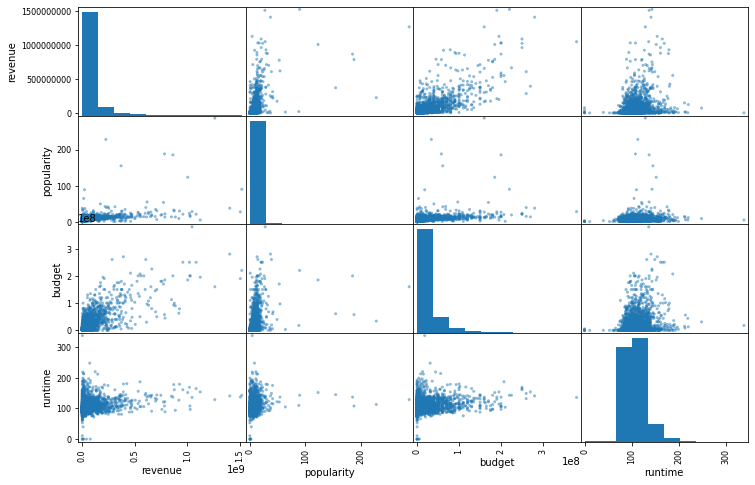

In [26]:
attributes = ["revenue", "popularity", "budget",
 "runtime"]
pd.plotting.scatter_matrix(train[attributes], figsize=(12, 8))

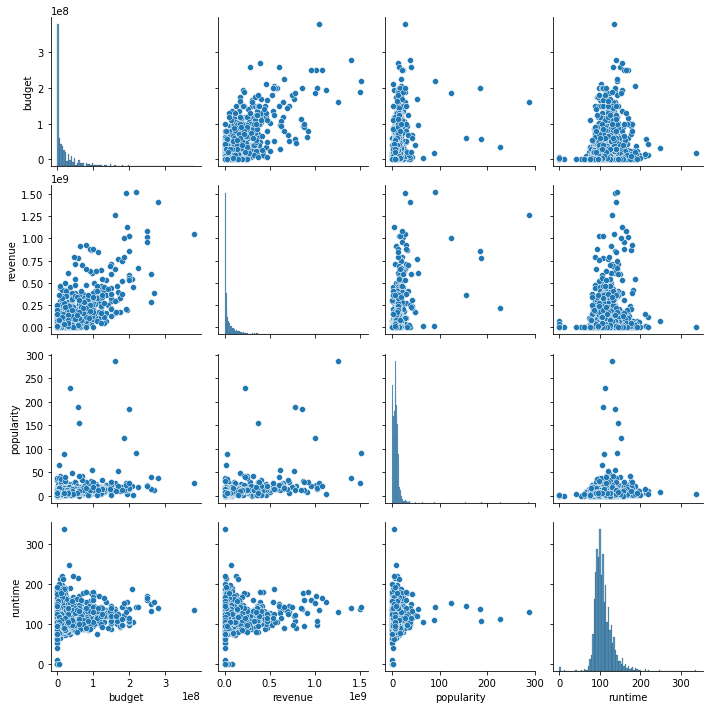

In [27]:
sns.pairplot(train[["budget","revenue", "popularity", "runtime"]])

In [28]:
df = train.copy()
X_train=train.drop("revenue", axis=1)
y_train=train["revenue"]

In [29]:
X_train.columns

Index(['index', 'id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew'],
      dtype='object')

---
# **4 : Prepare the data to better expose the underlying data patterns to machine learning algorithms**

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

class fix_features(BaseEstimator, TransformerMixin):
  def __init__(self):
        return
  def fit(self, X, y=None):
        return self
  def transform(self, X, y=None):
        features_to_fix=["belongs_to_collection", "genres", "production_companies", "production_countries",\
                        "Keywords"]

        for feature in features_to_fix:
            X.loc[X[feature].notnull(),feature]=\
            X.loc[X[feature].notnull(),feature].apply(lambda x : ast.literal_eval(x))\
            .apply(lambda x : [y["name"] for y in x])
        return X

class jsonish_to_list(BaseEstimator, TransformerMixin):
  def __init__(self):
        return
  def fit(self, X, y=None):
        return self
  def transform(self, X, y=None):
        X.loc[X["cast"].notnull(),"cast"]=X.loc[X["cast"].notnull(),"cast"].apply(lambda x : ast.literal_eval(x))
        X.loc[X["crew"].notnull(),"crew"]=X.loc[X["crew"].notnull(),"crew"].apply(lambda x : ast.literal_eval(x))
        return X

# Used to make a column for each genre, and will give bool value 1 if the movie has the spesific genre and 0 
# if it doesn't. 
class cat_to_bool(BaseEstimator, TransformerMixin):
  def __init__(self):
        return
  def fit(self, X, y=None):
        return self
  def transform(self, X, y=None):

  
        X["genre_Comedy"]=0
        X["genre_Drama"]=0
        X["genre_Thriller"]=0
        X["genre_Action"]=0
        X["genre_Animation"]=0
        X["genre_Horror"]=0
        X["genre_Documentary"]=0
        X["genre_Adventure"]=0
        X["genre_Crime"]=0
        X["genre_Mystery"]=0
        X["genre_Fantasy"]=0
        X["genre_War"]=0
        X["genre_SF"]=0
        X["genre_Romance"]=0
        X["genre_Music"]=0
        X["genre_Western"]=0
        X["genre_Family"]=0
        X["genre_History"]=0
        X["genre_Foreign"]=0
        X["genre_TM"]=0
        for i in range(len(X)):
          if isinstance(X["genres"][i], list):
            if "Comedy" in X["genres"][i]:
              X["genre_Comedy"][i] = 1
            if "Drama" in X["genres"][i]:
              X["genre_Drama"][i]=1
            if "Thriller" in X["genres"][i]:
              X["genre_Thriller"][i]=1
            if "Action" in X["genres"][i]:
              X["genre_Action"][i]=1
            if "Animation" in X["genres"][i]:
              X["genre_Animation"][i]=1
            if "Horror" in X["genres"][i]:
              X["genre_Horror"][i]=1
            if "Documentary" in X["genres"][i]:
              X["genre_Documentary"][i]=1
            if "Adventure" in X["genres"][i]:
              X["genre_Adventure"][i]=1
            if "Crime" in X["genres"][i]:
              X["genre_Crime"][i]=1
            if "Mystery" in X["genres"][i]:
              X["genre_Mystery"][i]=1
            if "Fantasy" in X["genres"][i]:
              X["genre_Fantasy"][i]=1
            if "War" in X["genres"][i]:
              X["genre_War"][i]=1
            if "Science Fiction" in X["genres"][i]:
              X["genre_SF"][i]=1
            if "Romance" in X["genres"][i]:
              X["genre_Romance"][i]=1
            if "Music" in X["genres"][i]:
              X["genre_Music"][i]=1
            if "Western" in X["genres"][i]:
              X["genre_Western"][i]=1
            if "Family" in X["genres"][i]:
              X["genre_Family"][i]=1
            if "History" in X["genres"][i]:
              X["genre_History"][i]=1
            if "Foreign" in X["genres"][i]:
              X["genre_Foreign"][i]=1
            if "TV Movie" in X["genres"][i]:
              X["genre_TM"][i]=1
      
        X.loc[X["homepage"].notnull(),"homepage"]=1
        X["homepage"]=X["homepage"].fillna(0)
          
        X["in_collection"]=1
        X.loc[X["belongs_to_collection"].isnull(),"in_collection"]=0

        X["has_tagline"]=1
        X.loc[X["tagline"].isnull(),"has_tagline"]=0

        X["isReleased"]=1
        X.loc[X["status"]!="Released","isReleased"]=0


        return X

# Used to split release_date into release_year, release_month, release_day, release_weekday and release_quarter
class split_release_date(BaseEstimator, TransformerMixin):
  def __init__(self):
        return
  def fit(self, X, y=None):
        return self
  def transform(self, X, y=None):
        release_date=pd.to_datetime(X["release_date"])
        X["release_year"]=release_date.dt.year
        X["release_month"]=release_date.dt.month
        X["release_day"]=release_date.dt.day
        X["release_wd"]=release_date.dt.dayofweek
        X["release_quarter"]=release_date.dt.quarter

        return X

class to_empty(BaseEstimator, TransformerMixin):
  def __init__(self):
        return
  def fit(self, X, y=None):
        return self
  def transform(self, X, y=None): 
        to_empty_list=["belongs_to_collection","Keywords","production_companies","production_countries","cast", "genres"] #Setter alle disse atributtene til den første verdien i listen.

        for feature in to_empty_list:
            X[feature] = X[feature].apply(lambda d: d[0] if isinstance(d, list) and d!=[] else 0)
        
        return X


class to_zero(BaseEstimator, TransformerMixin):
  def __init__(self):
        return
  def fit(self, X, y=None):
        return self
  def transform(self, X, y=None):
        to_zero_list=["runtime","release_month","release_year","release_wd","release_quarter","release_day"]
        for f in to_zero_list:
            X[f]=X[f].fillna(0) 
        return X


# Drops unnecessary attributes
class dropAttribs(BaseEstimator, TransformerMixin):
  def __init__(self):
        return
  def fit(self, X, y=None):
        return self
  def transform(self, X, y=None):
        to_drop_list = ["index", "original_title", "belongs_to_collection", "genres", "id", "isReleased", "imdb_id","overview","poster_path","tagline","status","release_date","spoken_languages","crew", "cast", "poster_path", "belongs_to_collection","original_language", "original_title", "production_companies", "production_countries", "title", "Keywords"]
        X = X.drop(to_drop_list,axis=1)
        print(X.columns)
        return X

In [31]:
def prepData(X):
  df_t = fix_features()        .transform(X)
  df_t = jsonish_to_list()     .transform(df_t)
  df_t = cat_to_bool()         .transform(df_t)
  df_t = split_release_date()  .transform(df_t)
  df_t = to_empty()            .transform(df_t)
  df_t = to_zero()             .transform(df_t)
  df_t = dropAttribs()         .transform(df_t)
  return pd.DataFrame(df_t)

In [32]:
X_train2 = X_train.copy()
train_prepared = prepData(X_train2)

Index(['budget', 'homepage', 'popularity', 'runtime', 'genre_Comedy',
       'genre_Drama', 'genre_Thriller', 'genre_Action', 'genre_Animation',
       'genre_Horror', 'genre_Documentary', 'genre_Adventure', 'genre_Crime',
       'genre_Mystery', 'genre_Fantasy', 'genre_War', 'genre_SF',
       'genre_Romance', 'genre_Music', 'genre_Western', 'genre_Family',
       'genre_History', 'genre_Foreign', 'genre_TM', 'in_collection',
       'has_tagline', 'release_year', 'release_month', 'release_day',
       'release_wd', 'release_quarter'],
      dtype='object')


In [33]:
train_prepared

,budget,homepage,popularity,runtime,genre_Comedy,genre_Drama,genre_Thriller,genre_Action,genre_Animation,genre_Horror,genre_Documentary,genre_Adventure,genre_Crime,genre_Mystery,genre_Fantasy,genre_War,genre_SF,genre_Romance,genre_Music,genre_Western,genre_Family,genre_History,genre_Foreign,genre_TM,in_collection,has_tagline,release_year,release_month,release_day,release_wd,release_quarter
0,1601792,0,2.329513,96.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2005,5,15,6,2
1,5000000,0,3.621052,116.0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1998,1,30,4,1
2,700000,0,11.118844,112.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2032,5,25,1,2
3,0,0,1.051148,94.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013,9,6,4,3
4,0,1,11.069608,112.0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2009,9,9,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,30000000,1,6.347850,105.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1993,11,11,3,4
2396,0,0,7.872569,145.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2069,9,10,1,3
2397,0,0,0.851599,75.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2001,5,11,4,2
2398,19000000,0,6.701138,91.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1986,5,23,4,2


In [34]:
# Checking that we have no null-values
train_prepared.isna().sum()

budget               0
homepage             0
popularity           0
runtime              0
genre_Comedy         0
genre_Drama          0
genre_Thriller       0
genre_Action         0
genre_Animation      0
genre_Horror         0
genre_Documentary    0
genre_Adventure      0
genre_Crime          0
genre_Mystery        0
genre_Fantasy        0
genre_War            0
genre_SF             0
genre_Romance        0
genre_Music          0
genre_Western        0
genre_Family         0
genre_History        0
genre_Foreign        0
genre_TM             0
in_collection        0
has_tagline          0
release_year         0
release_month        0
release_day          0
release_wd           0
release_quarter      0
dtype: int64

---
# **5 : Explore many different models and short-list the best ones**

In [35]:
#Importing cross_val_score and mse used in evaluating of the algorithms
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

#Making a function to display score value
class displaySaver():
    
    def __init__(self):
        self.methodsTested = np.array(["Name", "Mean", "Standard deviation", "RMSE"])
        
    def getMethods(self):
        return pd.DataFrame(self.methodsTested)

    def displayAdd_score(self, scores, name, rmse):
        self.add_score(scores, name, rmse)
        self.display_score(scores, name, rmse)
        
    def add_score(self, scores, name, rmse):
        self.methodsTested = np.vstack([ self.methodsTested, [name, scores.mean(), scores.std(), rmse] ])
        
    def display_score(self, scores, name, rmse):
        print("Method: ", name, 
              "\nScore on training set: ", rmse,
              "\nScores: ", scores, 
              "\nMean: ", scores.mean(), 
              "\nStandard deviation: ", scores.std())
    def min(self, num=3):
      return pd.DataFrame(self.methodsTested[np.argsort(self.methodsTested[:,3])][:3])
        
d = displaySaver()
train_labels = y_train

In [36]:
#LinearRegression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

#Training lin_reg
lin_reg.fit(train_prepared, train_labels) 

#Finding rmse
train_pred = lin_reg.predict(train_prepared)
lin_mse = mean_squared_error(train_labels, train_pred)
lin_rmse = np.sqrt(lin_mse)

#Finding cross_val_score
scores = cross_val_score(lin_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

#Add result to d
d.add_score(lin_rmse_scores, "Linear Regression", lin_rmse)

In [37]:
#DecisionTree
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()

#Training
tree_reg.fit(train_prepared, train_labels) 

#Finding rmse
tree_preds = tree_reg.predict(train_prepared)
tree_mse = mean_squared_error(train_labels, tree_preds)
tree_rmse = np.sqrt(tree_mse)

#Finding cross_val_score
scores = cross_val_score(tree_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

#Add result to d
d.add_score(tree_rmse_scores,"Decision Tree", tree_rmse)

In [38]:
#RandomForest
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()

#Training forest-regressor
forest_reg.fit(train_prepared, train_labels)

#Finding rmse
forest_preds = forest_reg.predict(train_prepared)
forest_mse = mean_squared_error(train_labels, forest_preds)
forest_rmse = np.sqrt(forest_mse)

#Finding cross-val-score
scores = cross_val_score(forest_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

#Add result to d
d.add_score(forest_rmse_scores, "Random Forest", forest_rmse)

In [39]:
#SVR using radial basis function-kernal
from sklearn import svm
svr_reg = svm.SVR()

#Training svm
svr_reg.fit(train_prepared, train_labels)

#Finding rmse
svr_preds = svr_reg.predict(train_prepared)
svr_mse = mean_squared_error(train_labels, forest_preds)
svr_rmse = np.sqrt(svr_mse)

#Finding cross-val-score
scores = cross_val_score(svr_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-scores)

#Add result to d
d.add_score(svr_rmse_scores, "SVR using rbf-kernal", svr_rmse)

In [40]:
#SVR using poly-kernal
svr_reg = svm.SVR(kernel='poly')

#Training svm
svr_reg.fit(train_prepared, train_labels)

#Finding rmse
svr_preds = svr_reg.predict(train_prepared)
svr_mse = mean_squared_error(train_labels, forest_preds)
svr_rmse = np.sqrt(svr_mse)

#Finding cross-val-score
scores = cross_val_score(svr_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-scores)

#Add result to d
d.add_score(svr_rmse_scores, "SVR using poly-kernal", svr_rmse)

In [41]:
#SVR using sigmoid-kernal
svr_reg = svm.SVR(kernel='sigmoid')

#Training svm
svr_reg.fit(train_prepared, train_labels)

#Finding rmse
svr_preds = svr_reg.predict(train_prepared)
svr_mse = mean_squared_error(train_labels, forest_preds)
svr_rmse = np.sqrt(svr_mse)

#Finding cross-val-score
scores = cross_val_score(svr_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-scores)

#Add result to d
d.add_score(svr_rmse_scores, "SVR using sigmoid-kernal", svr_rmse)

In [42]:
#NuSVR
nuSvr_reg = svm.NuSVR()

#Training NuSVR
nuSvr_reg.fit(train_prepared, train_labels)

#Finding rmse
nuSvr_preds = nuSvr_reg.predict(train_prepared)
nuSvr_mse = mean_squared_error(nuSvr_preds, train_labels)
nuSvr_rmse = np.sqrt(nuSvr_mse)

#Finding cross-val-score
scores = cross_val_score(nuSvr_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
nuSvr_rmse_scores = np.sqrt(-scores)

#Add result to d
d.add_score(nuSvr_rmse_scores, "NuSVR", nuSvr_rmse)

In [43]:
#LinSVR
linSvr_reg = svm.LinearSVR()

#Training linearSVR
linSvr_reg.fit(train_prepared, train_labels)

#Finding rmse
linSvr_pred = linSvr_reg.predict(train_prepared)
linSvr_mse = mean_squared_error(linSvr_pred, train_labels)
linSvr_rmse = np.sqrt(linSvr_mse)

#Finding cross-val-score
score = cross_val_score(linSvr_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
linSvr_rmse_scores = np.sqrt(-scores)

#Add result to d
d.add_score(linSvr_rmse_scores, "LinearSVR", linSvr_rmse)

In [44]:
d.getMethods()

,0,1,2,3
0,Name,Mean,Standard deviation,RMSE
1,Linear Regression,81024165.52215704,16149633.26129551,80871366.67006582
2,Decision Tree,102866234.55292691,14358367.842967652,0.0
3,Random Forest,75038382.26911142,14549744.842635386,29119855.104858838
4,SVR using rbf-kernal,144677993.92535812,28456047.257986944,29119855.104858838
5,SVR using poly-kernal,144593919.5555288,28429460.490185976,29119855.104858838
6,SVR using sigmoid-kernal,144678008.7695709,28456038.782427575,29119855.104858838
7,NuSVR,139239256.21589926,28878761.70597626,142198509.54533872
8,LinearSVR,139239256.21589926,28878761.70597626,100997089.85081846


### We see that Decision tree is overfitting, so we pick LinearSVR.


---
# **6 : Fine-tune your models and combine them into a great solution**

To avoid having to manually change the hyperparameters and fit them on the training data we use gridsearch. This allows us to select the best params

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'max_iter': [500, 600 ,700, 800], 
    'dual': [True, False], 
    'fit_intercept': [True, False], 
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'intercept_scaling': [1.2, 1.5, 1.7] },]

lin_svr = svm.LinearSVR()

grid_search = GridSearchCV(
    lin_svr, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
    )


In [46]:
grid_search.fit(train_prepared, train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                 fit_intercept=True, intercept_scaling=1.0,
                                 loss='epsilon_insensitive', max_iter=1000,
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'dual': [True, False], 'fit_intercept': [True, False],
                          'intercept_scaling': [1.2, 1.5, 1.7],
                          'loss': ['epsilon_insensitive',
                                   'squared_epsilon_insensitive'],
                          'max_iter': [500, 600, 700, 800]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [47]:
grid_search.best_estimator_

LinearSVR(C=1.0, dual=False, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.2, loss='squared_epsilon_insensitive',
          max_iter=500, random_state=None, tol=0.0001, verbose=0)

In [48]:
#Use the result to run a new linSVR

linSvr2 = svm.LinearSVR(C=1.0, dual=False, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.5, loss='squared_epsilon_insensitive',
          max_iter=500, random_state=None, tol=0.0001, verbose=0)

#Training linearSVR2
linSvr2.fit(train_prepared, train_labels)

#Finding rmse
linSvr2_pred = linSvr2.predict(train_prepared)
linSvr2_mse = mean_squared_error(linSvr2_pred, train_labels)
linSvr2_rmse = np.sqrt(linSvr2_mse)

#Finding cross-val-score
score = cross_val_score(linSvr2, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
linSvr2_rmse_scores = np.sqrt(-scores)

#Add result to d
d.add_score(linSvr2_rmse_scores, "LinearSVR2", linSvr2_rmse)

In [49]:
d.getMethods()

,0,1,2,3
0,Name,Mean,Standard deviation,RMSE
1,Linear Regression,81024165.52215704,16149633.26129551,80871366.67006582
2,Decision Tree,102866234.55292691,14358367.842967652,0.0
3,Random Forest,75038382.26911142,14549744.842635386,29119855.104858838
4,SVR using rbf-kernal,144677993.92535812,28456047.257986944,29119855.104858838
5,SVR using poly-kernal,144593919.5555288,28429460.490185976,29119855.104858838
6,SVR using sigmoid-kernal,144678008.7695709,28456038.782427575,29119855.104858838
7,NuSVR,139239256.21589926,28878761.70597626,142198509.54533872
8,LinearSVR,139239256.21589926,28878761.70597626,100997089.85081846
9,LinearSVR2,139239256.21589926,28878761.70597626,92752871.71888205


We see that SVR2 has the same standard deviation, but a 
better RMSE.

Now to check the test:

In [50]:
X_test=test.drop("revenue", axis=1)
test_labels=test["revenue"]
test_prepared = prepData(X_test)


linSvr2_pred = linSvr2.predict(test_prepared)
linSvr2_mse = mean_squared_error(linSvr2_pred, test_labels)
linSvr2_rmse = np.sqrt(linSvr2_mse)

#Finding cross-val-score
score = cross_val_score(linSvr2, test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
linSvr2_rmse_scores = np.sqrt(-scores)

#Add result to d
d.add_score(linSvr2_rmse_scores, "LinearSVR2-Test", linSvr2_rmse)

#Displaying methods
d.getMethods()

Index(['budget', 'homepage', 'popularity', 'runtime', 'genre_Comedy',
       'genre_Drama', 'genre_Thriller', 'genre_Action', 'genre_Animation',
       'genre_Horror', 'genre_Documentary', 'genre_Adventure', 'genre_Crime',
       'genre_Mystery', 'genre_Fantasy', 'genre_War', 'genre_SF',
       'genre_Romance', 'genre_Music', 'genre_Western', 'genre_Family',
       'genre_History', 'genre_Foreign', 'genre_TM', 'in_collection',
       'has_tagline', 'release_year', 'release_month', 'release_day',
       'release_wd', 'release_quarter'],
      dtype='object')


,0,1,2,3
0,Name,Mean,Standard deviation,RMSE
1,Linear Regression,81024165.52215704,16149633.26129551,80871366.67006582
2,Decision Tree,102866234.55292691,14358367.842967652,0.0
3,Random Forest,75038382.26911142,14549744.842635386,29119855.104858838
4,SVR using rbf-kernal,144677993.92535812,28456047.257986944,29119855.104858838
5,SVR using poly-kernal,144593919.5555288,28429460.490185976,29119855.104858838
6,SVR using sigmoid-kernal,144678008.7695709,28456038.782427575,29119855.104858838
7,NuSVR,139239256.21589926,28878761.70597626,142198509.54533872
8,LinearSVR,139239256.21589926,28878761.70597626,100997089.85081846
9,LinearSVR2,139239256.21589926,28878761.70597626,92752871.71888205


Wow. It actually runs better on the test set. We can rule out overfitting.

In [51]:
#Testing for individual rows
test_row = pd.DataFrame(test_prepared.iloc[0].values.reshape(1,-1))
test_row.columns = test_prepared.columns

test_row2 = pd.DataFrame(test_prepared.iloc[1].values.reshape(1,-1))
test_row2.columns = test_prepared.columns

print('test1: ', linSvr2.predict(test_row))
print('test2: ', linSvr2.predict(test_row2))

test1:  [71295107.46015215]
test2:  [2.05329909e+08]


In [52]:
test_row2

,budget,homepage,popularity,runtime,genre_Comedy,genre_Drama,genre_Thriller,genre_Action,genre_Animation,genre_Horror,genre_Documentary,genre_Adventure,genre_Crime,genre_Mystery,genre_Fantasy,genre_War,genre_SF,genre_Romance,genre_Music,genre_Western,genre_Family,genre_History,genre_Foreign,genre_TM,in_collection,has_tagline,release_year,release_month,release_day,release_wd,release_quarter
0,72000000.0,0.0,11.211568,106.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2002.0,8.0,2.0,4.0,3.0


Seems to work. Nice.

In [53]:
# Export
#from joblib import dump
#dump(linSvr2, 'LinSVR.joblib')

---
###**(Step 7 and 8, presentation and launching, will be done through flask and a video.)**